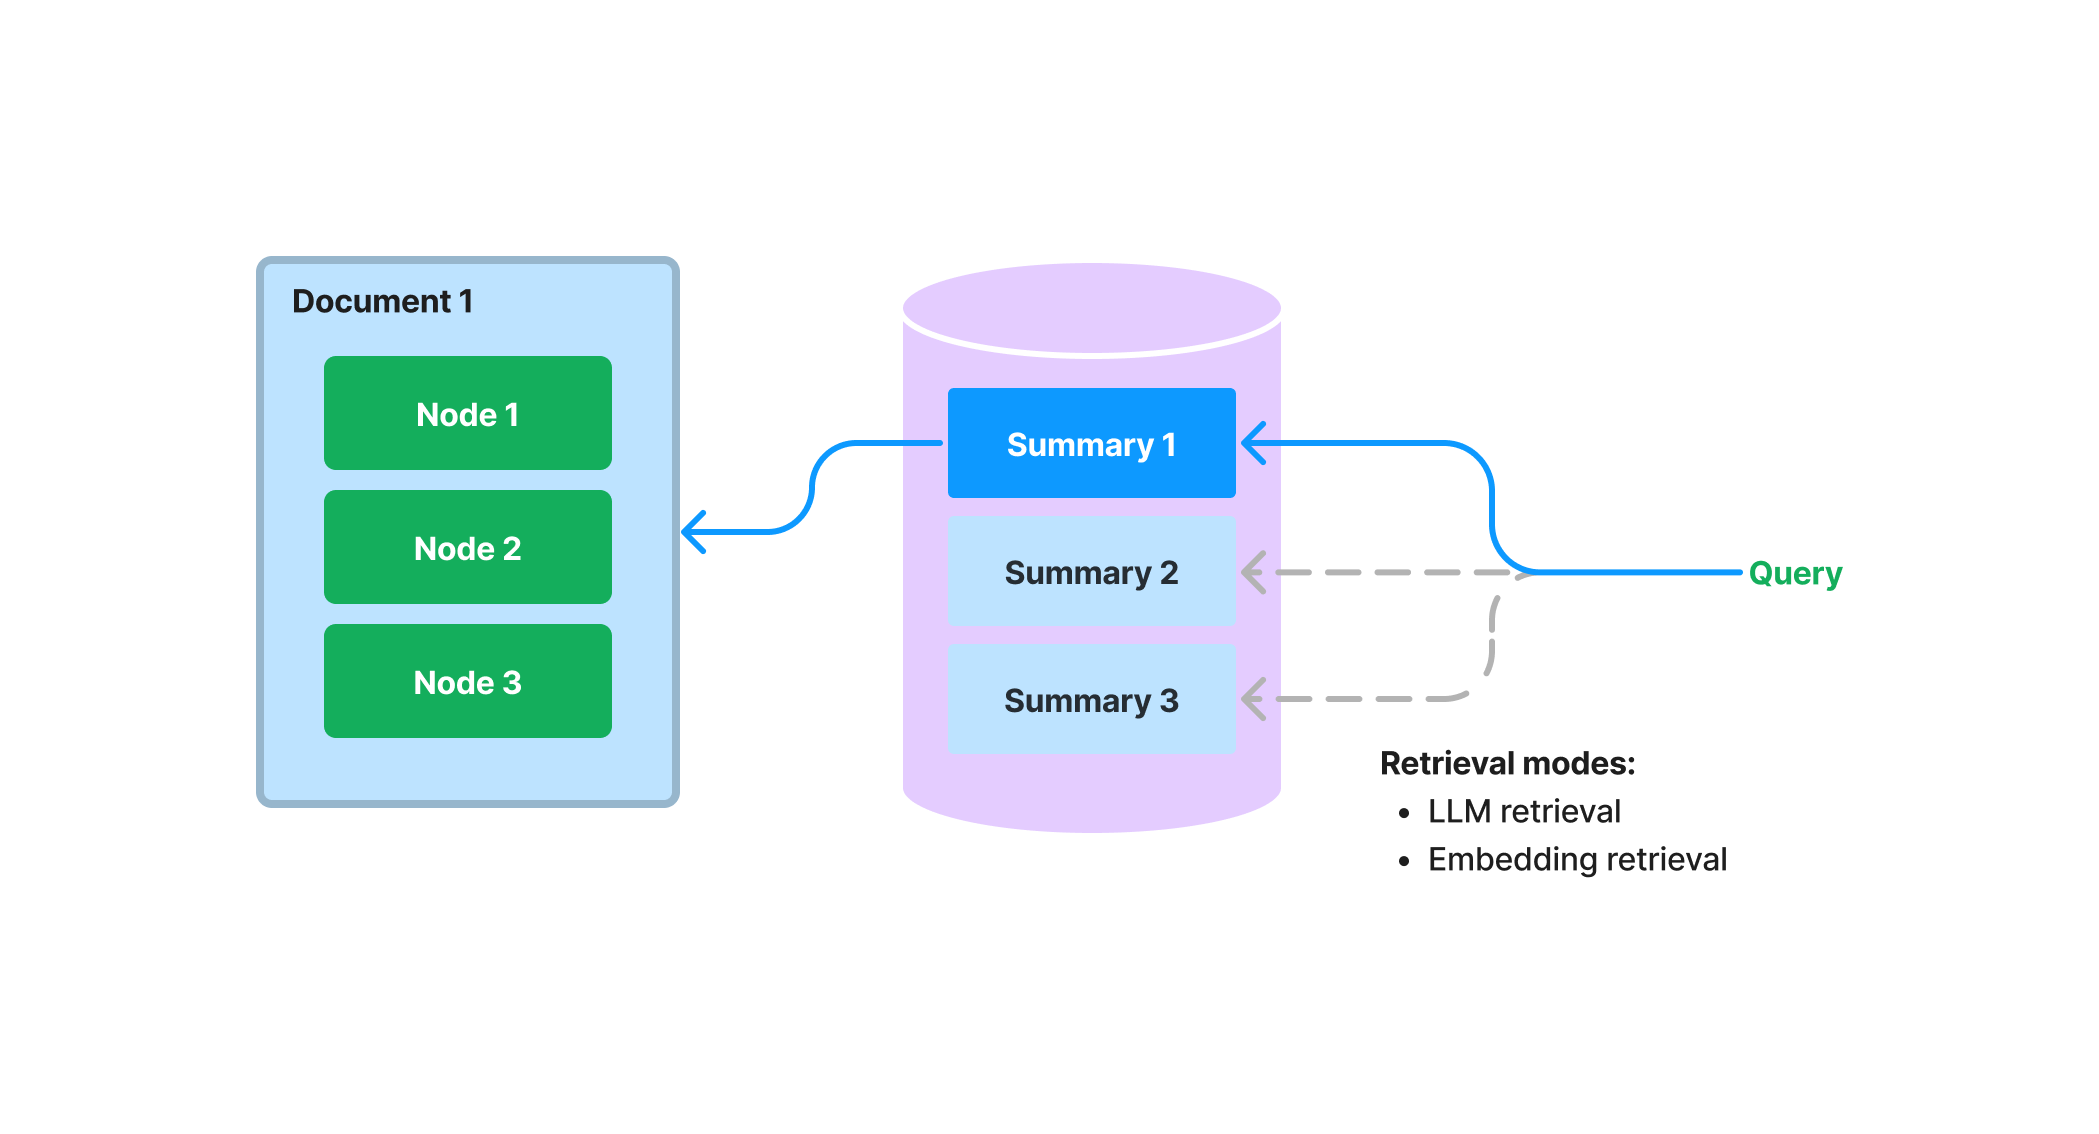

## Limitations of Existing Approaches
There are a few limitations of embedding retrieval using text chunks.

Text chunks lack global context. Oftentimes the question requires context beyond what is indexed in a specific chunk.
Careful tuning of top-k / similarity score thresholds. Make the value too small and you’ll miss context. Make the value too big and cost/latency might increase with more irrelevant context.
Embeddings don’t always select the most relevant context for a question. Embeddings are inherently determined separately between text and the context.
Adding keyword filters are one way to enhance the retrieval results. But that comes with its own set of challenges. We would need to adequately determine the proper keywords for each document, either manually or through an NLP keyword extraction/topic tagging model. Also we would need to adequately infer the proper keywords from the query.

## How It Works(Document Summary Index)
During build-time, we ingest each document, and use a LLM to extract a summary from each document. We also split the document up into text chunks (nodes). Both the summary and the nodes are stored within our Document Store abstraction. We maintain a mapping from the summary to the source document/nodes.

During query-time, we retrieve relevant documents to the query based on their summaries, using the following approaches:

LLM-based Retrieval: We present sets of document summaries to the LLM, and ask the LLM to determine which documents are relevant + their relevance score.
Embedding-based Retrieval: We retrieve relevant documents based on summary embedding similarity (with a top-k cutoff).
Note that this approach of retrieval for document summaries (even with the embedding-based approach) is different than embedding-based retrieval over text chunks. The retrieval classes for the document summary index retrieve all nodes for any selected document, instead of returning relevant chunks at the node-level.

Storing summaries for a document also enables LLM-based retrieval. Instead of feeding the entire document to the LLM in the beginning, we can first have the LLM inspect the concise document summary to see if it’s relevant to the query at all. This leverages the reasoning capabilities of LLM’s which are more advanced than embedding-based lookup, but avoids the cost/latency of feeding the entire document to the LLM

Additional Insights
Document retrieval with summaries can be thought of as a “middle ground” between semantic search and brute-force summarization across all docs. We look up documents based on summary relevance with the given query, and then return all *nodes* corresponding to the retrieved docs.

Why should we do this? This retrieval method gives user more context than top-k over a text-chunk, by retrieving context at a document-level. But, it’s also a more flexible/automatic approach than topic modeling; no more worrying about whether your text has the right keyword tags!

In [ ]:
!pip install llama-index-llms-huggingface-api
!pip install llama-index-embeddings-huggingface
!pip install llama-index-llms-llama-cpp
!pip install llama-index
!pip install huggingface_hub
!pip install transformers
!pip install torch
!pip install gradio
!pip install llama-index-llms-huggingface
! pip install llama-index-llms-groq
!pip install llama-index-llms-gemini

In [4]:
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader
from llama_index.core.tools import QueryEngineTool, ToolMetadata
from llama_index.core.callbacks import CallbackManager, LlamaDebugHandler
from llama_index.core import ServiceContext, StorageContext
from llama_index.llms.huggingface import HuggingFaceLLM
from llama_index.llms.huggingface_api import HuggingFaceInferenceAPI
from llama_index.core import Settings
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.postprocessor import SimilarityPostprocessor
from llama_index.core import SimpleDirectoryReader, load_index_from_storage
import os
import nest_asyncio
import os
from huggingface_hub import login

from llama_index.core import SimpleDirectoryReader, get_response_synthesizer
from llama_index.core import DocumentSummaryIndex
from llama_index.core.node_parser import SentenceSplitter

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pydantic/_internal/_fields.py:161: UserWarning: Field "model_id" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [5]:
import nest_asyncio

nest_asyncio.apply()

In [6]:
import logging
import sys

logging.basicConfig(stream=sys.stdout, level=logging.WARNING)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

# # Uncomment if you want to temporarily disable logger
#logger = logging.getLogger()
#logger.disabled = True

In [ ]:
#if you wann run on your local compute 

from llama_index.llms.llama_cpp import LlamaCPP

def messages_to_prompt(messages):
    prompt = ""
    for message in messages:
        if message.role == 'system':
            prompt += f"<|system|>\n{message.content}</s>\n"
        elif message.role == 'user':
            prompt += f"<|user|>\n{message.content}</s>\n"
        elif message.role == 'assistant':
            prompt += f"<|assistant|>\n{message.content}</s>\n"

    # ensure we start with a system prompt, insert blank if needed
    if not prompt.startswith("<|system|>\n"):
        prompt = "<|system|>\n</s>\n" + prompt

    # add final assistant prompt
    prompt = prompt + "<|assistant|>\n"

    return prompt

def completion_to_prompt(completion):
    return f"<|system|>\n</s>\n<|user|>\n{completion}</s>\n<|assistant|>\n"

model_url = "https://huggingface.co/TheBloke/zephyr-7B-beta-GGUF/resolve/main/zephyr-7b-beta.Q4_0.gguf"

llm = LlamaCPP(
    model_url=model_url,
    model_path=None,
    temperature=0.1,
    max_new_tokens=2000,
    context_window= 32769,
    generate_kwargs={},
    messages_to_prompt=messages_to_prompt,
    completion_to_prompt=completion_to_prompt,
    verbose=True,
)

response = llm.complete("Hello, how are you?")
print(str(response))

In [7]:
##If you wish for groq =API
#from llama_index.llms.groq import Groq

#Settings.llm = Groq(model="llama-3.1-70b-versatile", api_key="gsk_..........")

In [ ]:
#--------------------------------------------------------------------------
#If you wish for huggingfaceAPI
#HF_TOKEN = "hf_.............." 
#login(token=HF_TOKEN)
#os.environ['HuggingFace_API_TOKEN'] = HF_TOKEN

# Settings.llm = HuggingFaceInferenceAPI(model_name = "meta-llama/Meta-Llama-3-8B-Instruct", token=HF_TOKEN)

#-----------------------------------
#from llama_index.llms.gemini import Gemini

#Settings.llm = Gemini(model="models/gemini-1.5-flash", api_key="AI..............")
#resp = llm.complete("Write a poem about a magic backpack")
#print(resp)

SyntaxError: invalid syntax (2752512220.py, line 5)

In [15]:
#from llama_index.llms.gemini import Gemini

#Settings.llm = Gemini(model="models/gemini-1.5-flash", api_key="AI....................")
#resp = llm.complete("Write a poem about a magic backpack")
#print(resp)

In [16]:
embed_model = HuggingFaceEmbedding(model_name="thenlper/gte-large")
Settings.embed_model = embed_model

In [ ]:
# LLM (gpt-3.5-turbo)
llm = Settings.llm
splitter = SentenceSplitter(chunk_size=4000)

In [ ]:
# DO NOT RUN to use index
#Define the directory containing the articles
reader = SimpleDirectoryReader(input_dir="./bill24")
# Load documents with parallel processing
documents = reader.load_data(num_workers=4)
print(f"Loaded {len(documents)} documents.")

# default mode of building the index
response_synthesizer = get_response_synthesizer(
    response_mode="tree_summarize",use_async=True
)
doc_summary_index = DocumentSummaryIndex.from_documents(
    documents,
    llm=llm,
    transformations=[splitter],
    response_synthesizer=response_synthesizer,
    show_progress=True,
)

doc_summary_index.storage_context.persist("index_bill24")


In [17]:

#from llama_index.core import load_index_from_storage
#from llama_index.core import StorageContext
# rebuild storage context
storage_context1 = StorageContext.from_defaults(persist_dir="./index_bill1")
index_bill1 = load_index_from_storage(storage_context1)

storage_context2 = StorageContext.from_defaults(persist_dir="./index_bill2")
index_bill2 = load_index_from_storage(storage_context2)

storage_context3 = StorageContext.from_defaults(persist_dir="./index_bill3")
index_bill3 = load_index_from_storage(storage_context3)

storage_context4 = StorageContext.from_defaults(persist_dir="./index_bill4")
index_bill4 = load_index_from_storage(storage_context4)

storage_context5 = StorageContext.from_defaults(persist_dir="./index_bill5")
index_bill5 = load_index_from_storage(storage_context5)

storage_context6 = StorageContext.from_defaults(persist_dir="./index_bill6")
index_bill6 = load_index_from_storage(storage_context6)

storage_context7 = StorageContext.from_defaults(persist_dir="./index_bill7")
index_bill7 = load_index_from_storage(storage_context7)

storage_context8 = StorageContext.from_defaults(persist_dir="./index_bill8")
index_bill8 = load_index_from_storage(storage_context8)

storage_context9 = StorageContext.from_defaults(persist_dir="./index_bill9")
index_bill9 = load_index_from_storage(storage_context9)

storage_context10 = StorageContext.from_defaults(persist_dir="./index_bill10")
index_bill10 = load_index_from_storage(storage_context10)

storage_context11 = StorageContext.from_defaults(persist_dir="./index_bill11")
index_bill11 = load_index_from_storage(storage_context11)

storage_context12 = StorageContext.from_defaults(persist_dir="./index_bill12")
index_bill12 = load_index_from_storage(storage_context12)

storage_context13 = StorageContext.from_defaults(persist_dir="./index_bill13")
index_bill13 = load_index_from_storage(storage_context13)

storage_context14 = StorageContext.from_defaults(persist_dir="./index_bill14")
index_bill14 = load_index_from_storage(storage_context14)

storage_context15 = StorageContext.from_defaults(persist_dir="./index_bill15")
index_bill15 = load_index_from_storage(storage_context15)

storage_context16 = StorageContext.from_defaults(persist_dir="./index_bill16")
index_bill16 = load_index_from_storage(storage_context16)

storage_context17 = StorageContext.from_defaults(persist_dir="./index_bill17")
index_bill17 = load_index_from_storage(storage_context17)

storage_context18 = StorageContext.from_defaults(persist_dir="./index_bill18")
index_bill18 = load_index_from_storage(storage_context18)

storage_context19 = StorageContext.from_defaults(persist_dir="./index_bill19")
index_bill19 = load_index_from_storage(storage_context19)

storage_context20 = StorageContext.from_defaults(persist_dir="./index_bill20")
index_bill20 = load_index_from_storage(storage_context20)

storage_context21 = StorageContext.from_defaults(persist_dir="./index_bill21")
index_bill21 = load_index_from_storage(storage_context21)

storage_context22 = StorageContext.from_defaults(persist_dir="./index_bill22")
index_bill22 = load_index_from_storage(storage_context22)

storage_context23 = StorageContext.from_defaults(persist_dir="./index_bill23")
index_bill23 = load_index_from_storage(storage_context23)

storage_context24 = StorageContext.from_defaults(persist_dir="./index_bill24")
index_bill24 = load_index_from_storage(storage_context24)

storage_context25 = StorageContext.from_defaults(persist_dir="./index_bill25")
index_bill25 = load_index_from_storage(storage_context25)

storage_context26 = StorageContext.from_defaults(persist_dir="./index_bill26")
index_bill26 = load_index_from_storage(storage_context26)

storage_context27 = StorageContext.from_defaults(persist_dir="./index_bill27")
index_bill27 = load_index_from_storage(storage_context27)

storage_context28 = StorageContext.from_defaults(persist_dir="./index_bill28")
index_bill28 = load_index_from_storage(storage_context28)

In [18]:
from llama_index.core.retrievers import QueryFusionRetriever

retriever = QueryFusionRetriever(
    [index_bill1.as_retriever(),
    index_bill2.as_retriever(),
    index_bill3.as_retriever(),
    index_bill4.as_retriever(),
    index_bill5.as_retriever(),
    index_bill6.as_retriever(),
    index_bill7.as_retriever(),
    index_bill8.as_retriever(),
    index_bill9.as_retriever(),
    index_bill10.as_retriever(),
    index_bill11.as_retriever(),
    index_bill12.as_retriever(),
    index_bill13.as_retriever(),
    index_bill14.as_retriever(),
    index_bill15.as_retriever(),
    index_bill16.as_retriever(),
    index_bill17.as_retriever(),
    index_bill18.as_retriever(),
    index_bill19.as_retriever(),
    index_bill20.as_retriever(),
    index_bill21.as_retriever(),
    index_bill22.as_retriever(),
    index_bill23.as_retriever(),
    index_bill24.as_retriever(),
    index_bill25.as_retriever(),
    index_bill26.as_retriever(),
    index_bill27.as_retriever(),
    index_bill28.as_retriever()],
    similarity_top_k=4,
    num_queries=1,  # set this to 1 to disable query generation
    use_async=True,
    verbose=True,
    query_gen_prompt= ("""\
You are a helpful QA assistant. Using the context information provided below, \
respond to the query accurately and comprehensively, relying solely on the context and not on any prior knowledge. \
Ensure your response is clear and concise.\
""")
)


In [15]:
#model default prompt

#QUERY_GEN_PROMPT = (
#    "You are a helpful assistant that generates multiple search queries based on a "
 #   "single input query. Generate {num_queries} search queries, one on each line, "
  #  "related to the following input query:\n"
   # "Query: {query}\n"
    # "Queries:\n"
# )

In [19]:
# use retriever as part of a query engine
from llama_index.core.query_engine import RetrieverQueryEngine

# configure response synthesizer
response_synthesizer = get_response_synthesizer(response_mode="tree_summarize")

# assemble query engine
query_engine = RetrieverQueryEngine(
    retriever=retriever,
    response_synthesizer=response_synthesizer,
)

# query


In [20]:
response = query_engine.query("What are the sports teams in Toronto?")
print(response)

This document does not contain information about sports teams in Toronto. 



In [21]:
response = query_engine.query("explain An Act respecting certain measures related"
"to COVID-19")
print(response)

This act authorizes the Minister of Health to make payments of up to $2.5 billion from the Consolidated Revenue Fund for expenses related to COVID-19 tests. It also allows the Minister to transfer COVID-19 tests and instruments used in relation to those tests to provinces, territories, and other bodies and persons in Canada. 



In [22]:
response = query_engine.query("list all context")
print(response)

The Online Streaming Act amends the Broadcasting Act to include online undertakings as a distinct class of broadcasting undertakings. It also specifies that the Act does not apply to programs uploaded to an online undertaking that provides a social media service by a user of the service, unless the programs are prescribed by regulation. The Act updates the broadcasting policy for Canada, enhancing the vitality of official language minority communities in Canada and fostering the full recognition and use of both English and French in Canadian society. It also provides the Commission with the power to require that persons carrying on broadcasting undertakings make expenditures to support the Canadian broadcasting system. 



In [23]:
response = query_engine.query("list all titles that you can answer")

from llama_index.core.response.notebook_utils import display_response

display_response(response)

**`Final Response:`** The provided text discusses amendments to the Criminal Code, Firearms Act, Nuclear Safety and Control Act, Immigration and Refugee Protection Act, and An Act to amend certain Acts and Regulations in relation to firearms.

In [16]:
#explore query_engines

In [18]:
retrieved_nodes = retriever.retrieve("explain covid")

print(len(retrieved_nodes))

print(retrieved_nodes[0].score)
print(retrieved_nodes[0].node.get_text())

4
None
Page 1 
First Session, Forty-fourth Parliament,
70-71 Elizabeth II, 2021-2022
STATUTES OF CANADA 2022
CHAPTER 2
An Act respecting certain measures related
to COVID-19
ASSENTED TO
MARCH 4, 2022
BILL C-10

Page 2 
RECOMMENDATION
Her Excellency the Governor General recommends to the House
of Commons the appropriation of public revenue under the cir-
cumstances, in the manner and for the purposes set out in a
measure entitled “An Act respecting certain measures related to
COVID-19”.
SUMMARY
This enactment authorizes the Minister of Health to make pay-
ments of up to $2.5 billion out of the Consolidated Revenue Fund
in relation to coronavirus disease 2019 (COVID-19) tests.
It also authorizes that Minister to transfer COVID-19 tests and in-
struments used in relation to those tests to the provinces and
territories and to bodies and persons in Canada.
Available on the House of Commons website at the following address:
www.ourcommons.ca
2021-2022

Page 3 
70-71 ELIZABETH II
CHAPTER 2
An

In [ ]:
retrieved_nodes = retriever.retrieve("An Act to provide for the establishment of a national council for reconciliation"
"ASSENTED TO APRIL 30, 2024"
"BILL C-29")

print(len(retrieved_nodes))

print(retrieved_nodes[0].score)
print(retrieved_nodes[0].node.get_text())